# QC Batch Report
This notebook creates a QC batch report for test results. It ties into the **Test Monitor Service** for retrieving filtered test results, the **Notebook Execution Service** for running outside of Jupyterhub, and the **Test Monitor Reports page** at #testmonitor/reports for displaying results.

The parameters and output use a schema recognized by the Test Monitor Reports page, which can be implemented by various report types. 

### Imports
Import Python modules for executing the notebook. Pandas is used for building and handling dataframes. Scrapbook is used for recording data for the Notebook Execution Service. The SystemLink Test Monitor Client provides access to test result data for processing.

In [1]:
import copy
from datetime import datetime
import pandas as pd
import scrapbook as sb
from dateutil import tz
import systemlink.clients.nifile as file_ingestion
import systemlink.clients.nitestmonitor as testmon
import time
import matplotlib.pyplot as plt
import re
import json
import numpy as np

### Parameters
- `group_by`: The dimension along which to reduce; what each bar in the output graph represents  
  Options: Day, System, Test Program, Operator, Part Number  
  Default: Day
- `results_filter`: Dynamic Linq query filter for test results from the Test Monitor Service  
  Options: Any valid Test Monitor Results Dynamic Linq filter  
  Default: `'startedWithin <= "30.0:0:0"'`

Parameters are also listed in the metadata for the parameters cell, along with their default values. The Notebook Execution services uses that metadata to pass parameters from the Test Monitor Reports page to this notebook. Available `group_by` options are listed in the metadata as well; the Test Monitor Reports page uses these to validate inputs sent to the notebook.

To see the metadata, select the code cell and click the wrench icon in the far left panel.

In [3]:
#results_filter = ''
results_filter = 'startedWithin <= "100.0:0:0" && programName.Contains("QC Wet") && properties["Lot Number"] = "20344-1"'
products_filter = ''
group_by = 'System'
Lot_Number = ''

### Mapping from grouping options to Test Monitor terminology
Translate the grouping options shown in the Test Monitor Reports page to keywords recognized by the Test Monitor API.

If I want to add group by custom property for example `Location` than we have to add a line of code as `'key': 'value pair'` `'('Location' : 'Location')'` value variable should match how it display in Test Monitor in `'group_map dict'`. 

In [4]:
groups_map = {
    'Day': 'started_at',
    'System': 'host_name',
    'Test Program': 'program_name',
    'Operator': 'operator',
    'Part Number': 'part_number',
    'Workspace': 'workspace'
}
grouping = groups_map[group_by]

### Create Test Monitor client
Establish a connection to SystemLink over HTTP.

In [5]:
# It just gets user login info automatically , not to worry about user name and password. Works well with User management auth
api_client = testmon.ApiClient()
results_api = testmon.ResultsApi(api_client)
steps_api = testmon.StepsApi(api_client)

### Query for results
Query the Test Monitor Service for results matching the `results_filter` parameter.

In [6]:
# This just creates object so that will be ready to send or use later below 
results_query = testmon.ResultsAdvancedQuery(
    results_filter, order_by=testmon.ResultField.STARTED_AT, take=1000)
results = []
# sending query and data comes back in JSoN, but python interprets data and display in good format depends on lib we use
response = await results_api.query_results_v2(post_body=results_query)
# response.results is nothing but fetching result values from response variable we have 

while response.continuation_token:
    results = results + response.results
    results_query.continuation_token = response.continuation_token
    response = await results_api.query_results_v2(post_body=results_query)

In [7]:
results_list = [result.to_dict() for result in results]
serial_number = []
result_id = []
for result in results_list:
        serial_number.append(result['serial_number'])  
        result_id.append(result['id'])
df_serial = {'Serial Number' : serial_number}
df_result_id = {'Result Id' : result_id}
display(len(serial_number))

18

### Query for test step

In [8]:
steps = []
steps_list=[]
start_time = datetime.now()
steps_filter = ''
for index,result in enumerate (result_id):
    if steps_filter == '':
        steps_filter += 'resultId == "' + result_id[index] + '"'
    else:
        steps_filter += ' || resultId == "' + result_id[index] + '"'
steps_filter = 'startedWithin <= "30.0:0:0" && (' + steps_filter + ')'

In [9]:
start_time = datetime.now()
steps_query = testmon.StepsAdvancedQuery(steps_filter , take=5000)
steps_results = []
response = await steps_api.query_steps_v2(post_body=steps_query)
while response.continuation_token:
    steps_results = steps_results + response.steps
    steps_query.continuation_token = response.continuation_token
    response = await steps_api.query_steps_v2(post_body=steps_query)
steps_list = [step.to_dict() for step in steps_results]   
end_time = datetime.now()
total_time =(end_time - start_time).total_seconds()
display('Total Time: {}'.format(total_time))

'Total Time: 0.093002'

In [10]:
df_steps = pd.DataFrame.from_records(steps_list)
modified_steps_list = []

for result  in result_id:
    df_single_result = df_steps[df_steps['result_id'] == result].copy()
    temp = pd.json_normalize(df_single_result["status"])
    df_single_result['status'] = temp['status_type'].to_list()
    df_single_result['name'] = df_single_result['data'].apply(lambda x: None if pd.isna(x) else None if len(x['parameters']) == 0 else x['parameters'][0]['name'])
    df_single_result['measurement'] = df_single_result['data'].apply(lambda x: None if pd.isna(x) else None if len(x['parameters']) == 0 else x['parameters'][0]['measurement'])
    df_single_result['lowLimit'] = df_single_result['data'].apply(lambda x: None if pd.isna(x) else None if len(x['parameters']) == 0 else x['parameters'][0]['lowLimit'])
    df_single_result['highLimit'] = df_single_result['data'].apply(lambda x: None if pd.isna(x) else None if len(x['parameters']) == 0 else x['parameters'][0]['highLimit'])
    modified_steps_list.append(df_single_result)
   

KeyError: 'result_id'

## For result
### Get group names
Collect the group name for each result based on the `group_by` parameter.

In [10]:
# group by is nothing but grouping with respect to key ( for exg operator) than it groups data which is filtered with respect to result filter , not on whol dat ain tets monitor
group_names = []
# result is like picking each element from result list and passing into for loop
for result in results_list:
        if grouping in result:
            group_names.append(result[grouping])

### Create pandas dataframe
Put the data into a dataframe whose columns are test result id, status, and group name.

In [12]:
formatted_results = {
    'id': [result['id'] for result in results_list],
    'Serial Number': [result['serial_number'] for result in results_list],
    'Product Number': [result['part_number'] for result in results_list],
    'status': [result['status']['status_type'] if result['status'] else None for result in results_list],
    'Operator': [result['operator'] for result in results_list],
    'program_name': [result['program_name'] for result in results_list],
    'started_at': [result['started_at'] for result in results_list],
    'properties': [result['properties'] for result in results_list],
    grouping: group_names
}

df_results = pd.DataFrame.from_dict(formatted_results)
properties = pd.json_normalize(df_results["properties"])
df_results = pd.concat([df_results.drop(["properties"], axis = 1), properties],axis =1 )
#axis = 1 , make everything horizontal

#convert serial name as into header
df_results = df_results.transpose()
df_results = df_results.rename(columns = pd.Series(serial_number))
df_results = df_results.transpose()

#remove /t and /n from the 'Aim of Testing'
aim=[]
for index,result in enumerate (result_id):
    s=df_results['Aim of Testing'].values[index]
    s_new = re.sub('\s+', ' ', s)
    aim.append(s_new)
df_aim = pd.DataFrame(aim, columns=['Aim of Testing'])
df_aim = df_aim.T.rename(columns = pd.Series(serial_number))
df_results = pd.concat([df_results.drop(["Aim of Testing"], axis = 1), df_aim.T],axis =1 )

#convert UTC timezone to local timezone
to_zone = tz.tzlocal()
utc = df_results['started_at']
def astimezone(x):
    return x.astimezone(to_zone)
# Convert time zone
central = utc.apply(astimezone)
df_results = pd.concat([df_results.drop(['started_at'],axis=1), central],axis=1)

NameError: name 'group_names' is not defined

## For Step List

#### Extract out 3 different tables
#### Algorithm Run Results, Panel Informations, Assay Parameters

In [13]:
limit=[]

df_results_step = modified_steps_list[0]

#table for Algorithm Run Results
df_algorithm = df_results_step.loc[df_results_step['path'].str.contains('Algorithm')].reset_index(drop=True)
df_algorithm = df_algorithm[['name']]
df_algorithm = df_algorithm.rename(columns = {'empty' : '', 'name' : 'Test_Name'})

#table for Panel Information
df_panel = df_results_step.loc[df_results_step['path'].str.contains('Panel')].reset_index(drop=True)
df_panel = df_panel[['name']]
df_panel = df_panel.rename(columns = {'empty' : '', 'name' : 'Panel_Information'})

#table for Assay Parameter
df_assay = df_results_step.loc[df_results_step['path'].str.contains('Assay')].reset_index(drop=True)
df_assay = df_assay[['name']]
df_assay = df_assay.rename(columns = {'empty' : '', 'name' : 'Test_Name'})

#get each result data
for index,result in enumerate (result_id):
    df_results_step = modified_steps_list[index]
    
    #Data for Algorithm Run Results
    df_algorithm_data = df_results_step.loc[df_results_step['path'].str.contains('Algorithm')].reset_index(drop=True)
    df_algorithm_data = df_algorithm_data['measurement']
    df_algorithm = pd.concat([df_algorithm,df_algorithm_data.rename(df_serial['Serial Number'][index])],axis=1)
    
    #Data for Panel Information
    df_panel_data = df_results_step.loc[df_results_step['path'].str.contains('Panel')].reset_index(drop=True)
    df_panel_data = df_panel_data['measurement']
    df_panel = pd.concat([df_panel,df_panel_data.rename(df_serial['Serial Number'][index])],axis=1)
    
    #Data for Assay Parameter
    df_assay_data = df_results_step.loc[df_results_step['path'].str.contains('Assay')].reset_index(drop=True)
    df_assay_data = df_assay_data['measurement']
    df_assay = pd.concat([df_assay,df_assay_data.rename(df_serial['Serial Number'][index])],axis=1)
    
    # to get the S5 limits
    df_limits = df_results_step[['name','lowLimit','highLimit']]
    df_limits = df_limits.dropna()
    if df_limits[df_limits['name'] == 'Delta.S5 (T1-T2)']['highLimit'].values[0].__contains__('NaN'):
        limit.append(df_limits[df_limits['name'] == 'Delta.S5 (T1-T2)']['lowLimit'].values[0])
    else:
        limit.append(df_limits[df_limits['name'] == 'Delta.S5 (T1-T2)']['highLimit'].values[0])

#change index to SN and header to test name (Algorithm Run Result)          
df_algorithm = df_algorithm.dropna(axis = 0,how='all').reset_index(drop=True)
df_algorithm = df_algorithm.transpose()
headers = df_algorithm.iloc[0]
df_algorithm = df_algorithm[1:].rename(columns=headers)

#change index to SN and header to test name (Panel Information)
df_panel = df_panel.dropna(axis = 0,how='all').reset_index(drop=True)
df_panel = df_panel.transpose()
headers = df_panel.iloc[0]
#check if headers contain NaN. If yes, duplicate from previous value
if headers.isnull().values.any():
    size=headers.str.contains('PI').count()
    headers = pd.DataFrame(headers.values.reshape(int(len(headers)/size),size))           
    headers = headers.fillna(method='ffill')
    headers = pd.Series(headers.values.ravel('C'))
df_panel = df_panel[1:].rename(columns=headers)

#change index to SN and header to test name (Assay Parameter)
df_assay = df_assay.dropna(axis = 0,how='all').reset_index(drop=True)
df_assay = df_assay.transpose()
headers = df_assay.iloc[0]
df_assay = df_assay[1:].rename(columns=headers)


#### Combine the table and add in required information

In [14]:
#combine all into 1 complete tables
df_report=pd.concat([df_algorithm,df_panel],axis=1)
df_report=pd.concat([df_report,df_assay],axis=1)

#add in panel type + operator + status + error explanation for filter
df_report = pd.concat([df_report,df_results['Panel Type']],axis=1)
df_report = pd.concat([df_report,df_results['Operator']],axis=1)
df_report = pd.concat([df_report,df_results['status']],axis=1)
df_report = pd.concat([df_report,df_results['Error Explanation']],axis=1)
df_report = pd.concat([df_report,df_results['Serial Number']],axis=1)

#add in S5 limit
df_limit = pd.DataFrame(limit, columns=['S5 limits'])
df_limit = df_limit.T.rename(columns = pd.Series(serial_number))
df_report = pd.concat([df_report,df_limit.T],axis=1)

#display(df_report)

### Sort Data (from Neg to Pos)

In [15]:
#sort data base on Panel Type (neg -> pos)
df_report = df_report.sort_values(by=['Panel Type'])
df_results = df_results.sort_values(by=['Panel Type'])

# Create table for PDF

### System Information

In [16]:
df_system_info = df_results[['QC Test Type' , 
                            'Station ID', 
                            'Operator' , 
                            'Job Number' , 
                            'Lot Number' , 
                            'Product Number' , 
                            'Product Name',
                            'Software Name',
                            'Software Version',
                            'Aim of Testing',
                            'Test System Type',
                            'Location',
                            'QC Test Experiment',
                            'Programming Lot',
                            'DUT Firmware Rev']]

s = df_system_info.stack().reset_index(level=0, drop=True)
s = s.groupby(level=0).unique().reindex(index=df_system_info.columns)

s["Start Time"] = df_results["started_at"].min()
s["End Time"] = df_results["started_at"].max()
s["Total Time"] = s["End Time"] - s["Start Time"]
df_system_info = s.to_frame()

#display(df_system_info)

### Negative Panel

In [17]:
# filter with negative Panel Type
negative_panel = df_report[df_report['Panel Type'] == 'Negative']

#Get all the data that start with "PI"
df_negative_panel = negative_panel[['Operator']]
for index,result in enumerate (negative_panel):
    if negative_panel.columns.values[index].__contains__('PI'):
        df_negative_panel=pd.concat([df_negative_panel,negative_panel[negative_panel.columns.values[index]]],axis=1)  
df_negative_panel=df_negative_panel.drop('PI.Type',axis=1)

s = df_negative_panel.stack().drop_duplicates().reset_index(level=0, drop=True)
s = s.groupby(level=0).unique().reindex(index=s.index)

df_negative_panel = s.to_frame().rename({'PI.Component' : 'Component No' , 
                                        'PI.Lot Number': 'Lot', 
                                        'PI.Expiry' : 'Expiry', 
                                        'PI.Dilution' : 'Dilution',
                                        'Operator' : 'Prepared By',
                                        'PI.Panel Prep Comments': 'Notes'})
#display(df_negative_panel)

### Positive Panel

In [18]:
# filter with positive Panel Type
positive_panel = df_report[df_report['Panel Type'] == 'Positive']

#Get all the data that start with "PI"
df_positive_panel = positive_panel[['Operator']]
for index,result in enumerate (positive_panel):
    if positive_panel.columns.values[index].__contains__('PI'):
        df_positive_panel=pd.concat([df_positive_panel,positive_panel[positive_panel.columns.values[index]]],axis=1)  
df_positive_panel=df_positive_panel.drop('PI.Type',axis=1)

s = df_positive_panel.stack().drop_duplicates().reset_index(level=0, drop=True)
s = s.groupby(level=0).unique().reindex(index=s.index)

df_positive_panel = s.to_frame().rename({'PI.Component' : 'Component No' , 
                                        'PI.Lot Number': 'Lot', 
                                        'PI.Expiry' : 'Expiry', 
                                        'PI.Dilution' : 'Dilution',
                                        'Operator' : 'Prepared By',
                                        'PI.Panel Prep Comments': 'Notes'})
#display(df_positive_panel)

### Assay Parameter

In [19]:
df = df_report[['Type','Component No','Lot No','Expiry']]

s = df.drop_duplicates().reset_index(level=0, drop=True)
s = s.columns.to_frame().T.append(s, ignore_index=True)
s.columns = range(len(s.columns))
s = s.transpose()

#Extract the Header
COLS = s[0].unique()
df_assay_panel = pd.DataFrame(columns=COLS)
for col in COLS:
    df_assay_panel[col]=s[s[0] == col][1].reset_index(drop=True)

df_assay_panel = df_assay_panel.transpose()

#display(df_assay_panel)

### Test Step

In [20]:
df_test_step = df_report[['T1.Conjugate Time',
                        'T2.Conjugate Time',
                        'Delta.Conjugate Time (T1-T2)',
                        'T1.Dry Average',
                        'T2.Dry Average',
                        'T1.Peak Time',
                        'T2.Peak Time',
                        'T1.Peak Value',
                        'T2.Peak Value',
                        'Control Value',
                        'Delta.S5 (T1-T2)',
                        'Delta.Delta S2-S1',
                        'Delta.Delta S3-S2',
                        'Delta.Delta S4-S3',
                        'Delta.Delta S5-S4',
                        'Algorithm Result',
                        'status']]
                    
df_test_step = df_test_step.rename(columns = {'T1.Conjugate Time' : 'T1 tconj',
                                            'T2.Conjugate Time' : 'T2 tconj',
                                            'Delta.Conjugate Time (T1-T2)' : 'Delta Conj',
                                            'T1.Dry Average' : 'Dry vT1',
                                            'T2.Dry Average' : 'Dry vT2',
                                            'T1.Peak Time' : 'T1 tpk',
                                            'T2.Peak Time' : 'T2 tpk',
                                            'T1.Peak Value' : 'T1 vpk',
                                            'T2.Peak Value' : 'T2 vpk ',
                                            'Control Value' : 'Control',
                                            'Delta.S5 (T1-T2)' : 'S5',
                                            'Delta.Delta S2-S1' : 'S2-S1',
                                            'Delta.Delta S3-S2' : 'S3-S2',
                                            'Delta.Delta S4-S3' : 'S4-S3',
                                            'Delta.Delta S5-S4' : 'S5-S4',
                                            'Algorithm Result' : 'Firmware result',
                                            'status' : 'Status'})


#display(df_test_step)

### Error List

In [21]:
# filter with positive Panel Type
error_panel = df_report[df_report['status'] == 'FAILED']

#create table
df_error_panel = error_panel[['Algorithm Result',
                             'Error Explanation']]

df_error_panel = df_error_panel.rename(columns = {'Algorithm Result' : 'Error',
                                                 'Error Explanation' : 'Reason'})

#display(df_error_panel)

# Plot Graph

### Scatter graph

C:\Program Files\National Instruments\Shared\Skyline\Python\3.8\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


2.494998

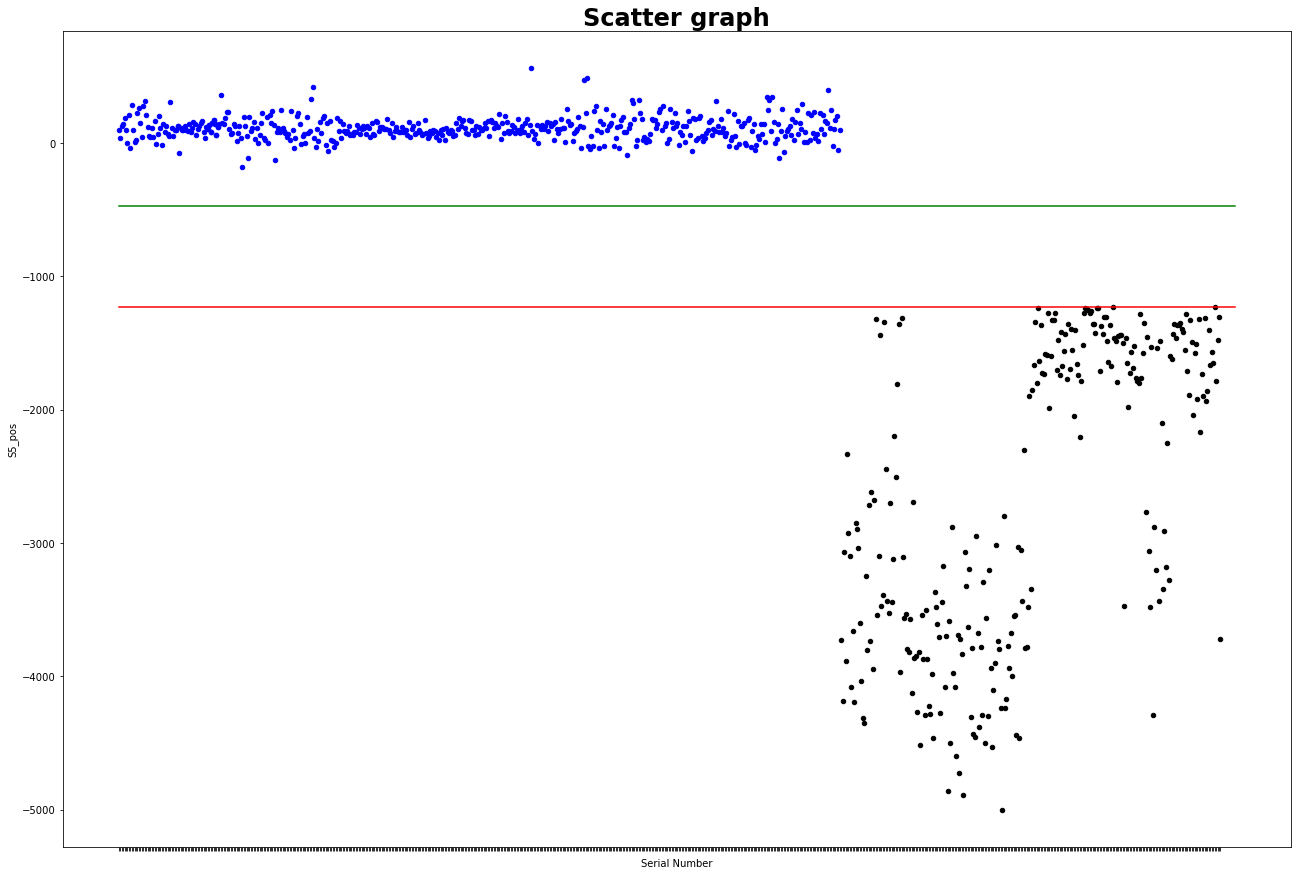

In [22]:
start_time = datetime.now()

#detect change of limit
for index, item in enumerate(df_report['S5 limits']):
    if index != 0:
        if df_report['S5 limits'][index] != df_report['S5 limits'][index-1]:
            flag=index

#create 2 dataframe for data (divide into pos and neg)
df_scatter_S5_neg = pd.DataFrame({'S5_neg':  pd.to_numeric(df_report['Delta.S5 (T1-T2)'][0:flag])})
df_scatter_S5_pos = pd.DataFrame({'S5_pos':  pd.to_numeric(df_report['Delta.S5 (T1-T2)'][flag::])})     
df_scatter_S5_new=pd.concat([df_scatter_S5_neg,df_scatter_S5_pos],axis=0)
df_scatter_S5_new=pd.concat([df_scatter_S5_new,df_report['Serial Number']],axis=1)

#create 2 dataframe for limit (divide into pos and neg)
df_scatter_limit_neg = pd.DataFrame({'neg_limit': pd.to_numeric(df_report['S5 limits'][flag-1])},index=df_report['Serial Number'])
df_scatter_limit_pos = pd.DataFrame({'pos_limit': pd.to_numeric(df_report['S5 limits'][flag+1])},index=df_report['Serial Number'])                                                       
df_limit=pd.concat([df_scatter_limit_neg,df_scatter_limit_pos],axis=1)


#create 4 plots in same graph
ax = df_scatter_S5_new.plot.scatter(x='Serial Number', y='S5_neg', color='b', grid=True)
ax = df_scatter_S5_new.plot.scatter(ax=ax, x='Serial Number', y='S5_pos', color='k', grid=True)
ax = df_limit.plot(ax=ax, y='neg_limit', color="g", rot=90, legend=False)
scatter_plot = df_limit.plot(ax=ax, y='pos_limit', color="r", rot=90, legend=False, figsize=(22,15))
scatter_plot.set_xticklabels([])
plt.title("Scatter graph",fontweight="bold", fontsize=24)

#save graph
scatter_plot.get_figure().savefig("C:/ProgramData/National Instruments/Skyline/JupyterHub/scatter_plot.png")
end_time = datetime.now()
total_time = (end_time - start_time).total_seconds()
display(total_time)


### Bar graph

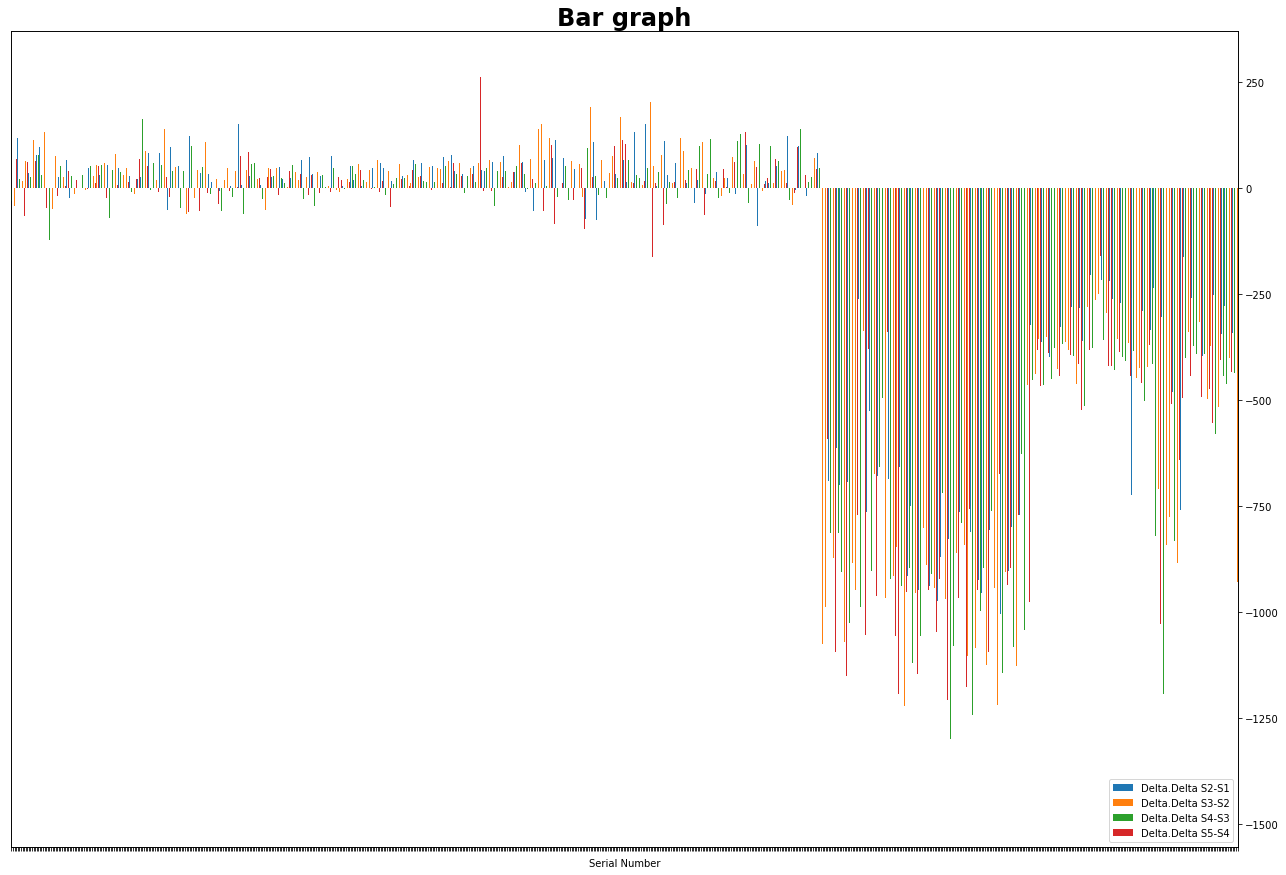

12.938

1.081999

In [23]:
start_time = datetime.now()
df_bar_graph = pd.DataFrame({
                    'Serial Number': df_report['Serial Number'],
                    'Delta.Delta S2-S1':  pd.to_numeric(df_report['Delta.Delta S2-S1']),
                    'Delta.Delta S3-S2':  pd.to_numeric(df_report['Delta.Delta S3-S2']),
                    'Delta.Delta S4-S3':  pd.to_numeric(df_report['Delta.Delta S4-S3']),
                    'Delta.Delta S5-S4':  pd.to_numeric(df_report['Delta.Delta S5-S4'])  })


# bar_plot = df_bar_graph.plot.scatter(x='Serial Number', y = 'Delta.Delta S5-S4',
#                                  legend=False, rot=90, grid = False, figsize=(22,15))
# bar_plot = df_bar_graph.plot.scatter(x='Serial Number', y = 'Delta.Delta S3-S2',
#                                  legend=False, rot=90, grid = False, figsize=(22,15), color = 'r', ax=bar_plot)
# bar_plot = df_bar_graph.plot.scatter(x='Serial Number', y = 'Delta.Delta S2-S1',
#                                  legend=False, rot=90, grid = False, figsize=(22,15), color = 'y', ax=bar_plot)
# bar_plot = df_bar_graph.plot.scatter(x='Serial Number', y = 'Delta.Delta S4-S3',
#                                  legend=False, rot=90, grid = False, figsize=(22,15), color = 'g', ax=bar_plot)
bar_plot = df_bar_graph.plot.bar(x='Serial Number', secondary_y=['Delta.Delta S2-S1','Delta.Delta S3-S2','Delta.Delta S4-S3','Delta.Delta S5-S4'], 
                                 legend=False, rot=90, grid = False, figsize=(22,15))
bar_plot.set_xticklabels([])
plt.legend(loc='lower right')
plt.title("Bar graph",fontweight="bold", fontsize=24)
plt.show()
end_time = datetime.now()
total_time = (end_time - start_time).total_seconds()
display(total_time)
start_time = datetime.now()
bar_plot.get_figure().savefig("C:/ProgramData/National Instruments/Skyline/JupyterHub/bar_plot.png")
end_time = datetime.now()
total_time = (end_time - start_time).total_seconds()
display(total_time)


### Box plot 1

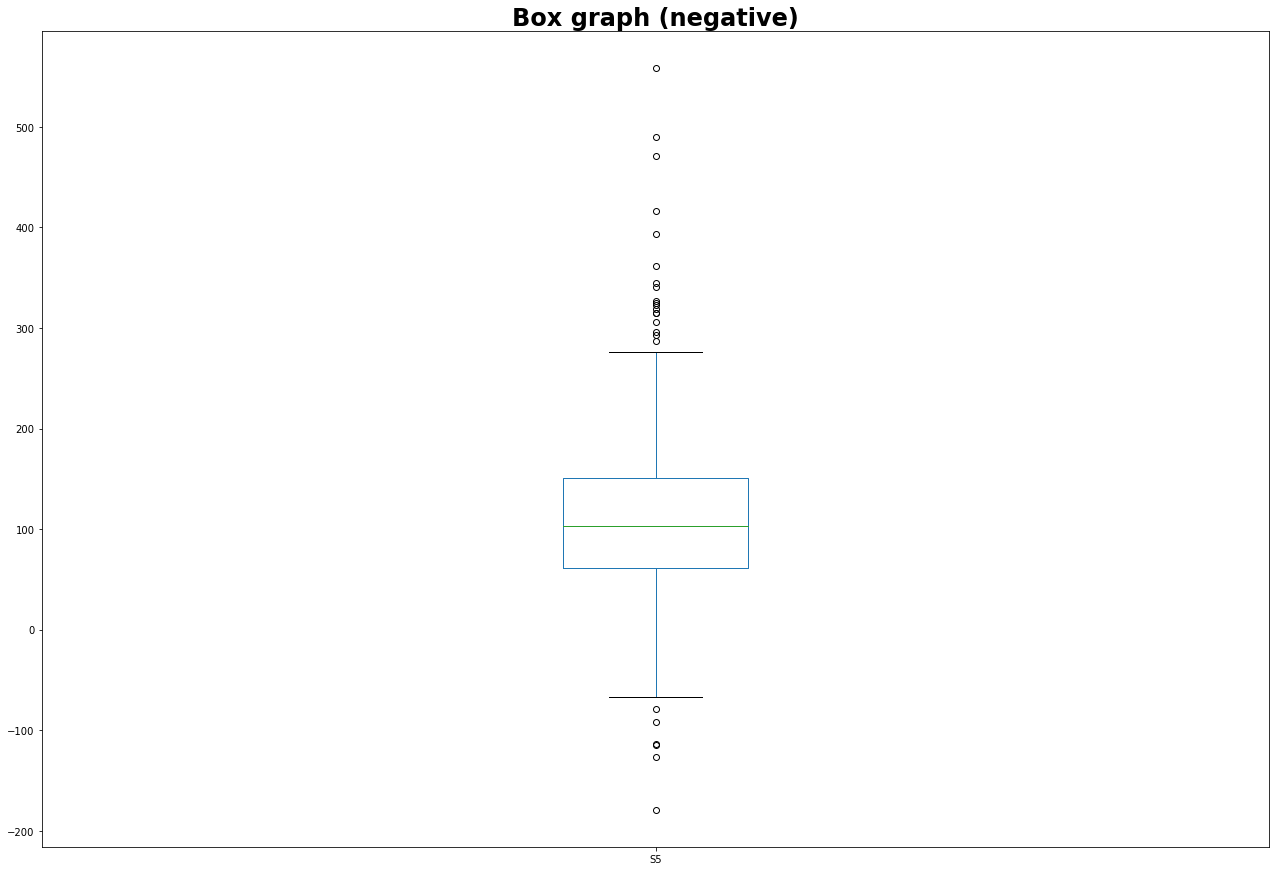

In [24]:
df_box_neg_graph = pd.DataFrame({
                    'Serial Number': negative_panel['Serial Number'],
                    'S5':  pd.to_numeric(negative_panel['Delta.S5 (T1-T2)']) })

box1_plot = df_box_neg_graph.plot.box(x='Serial Number', y='S5', legend = False, rot=0, figsize=(22,15))
plt.title("Box graph (negative)",fontweight="bold", fontsize=24)

box1_plot.get_figure().savefig("C:/ProgramData/National Instruments/Skyline/JupyterHub/box1_plot.png")


### Box plot 2

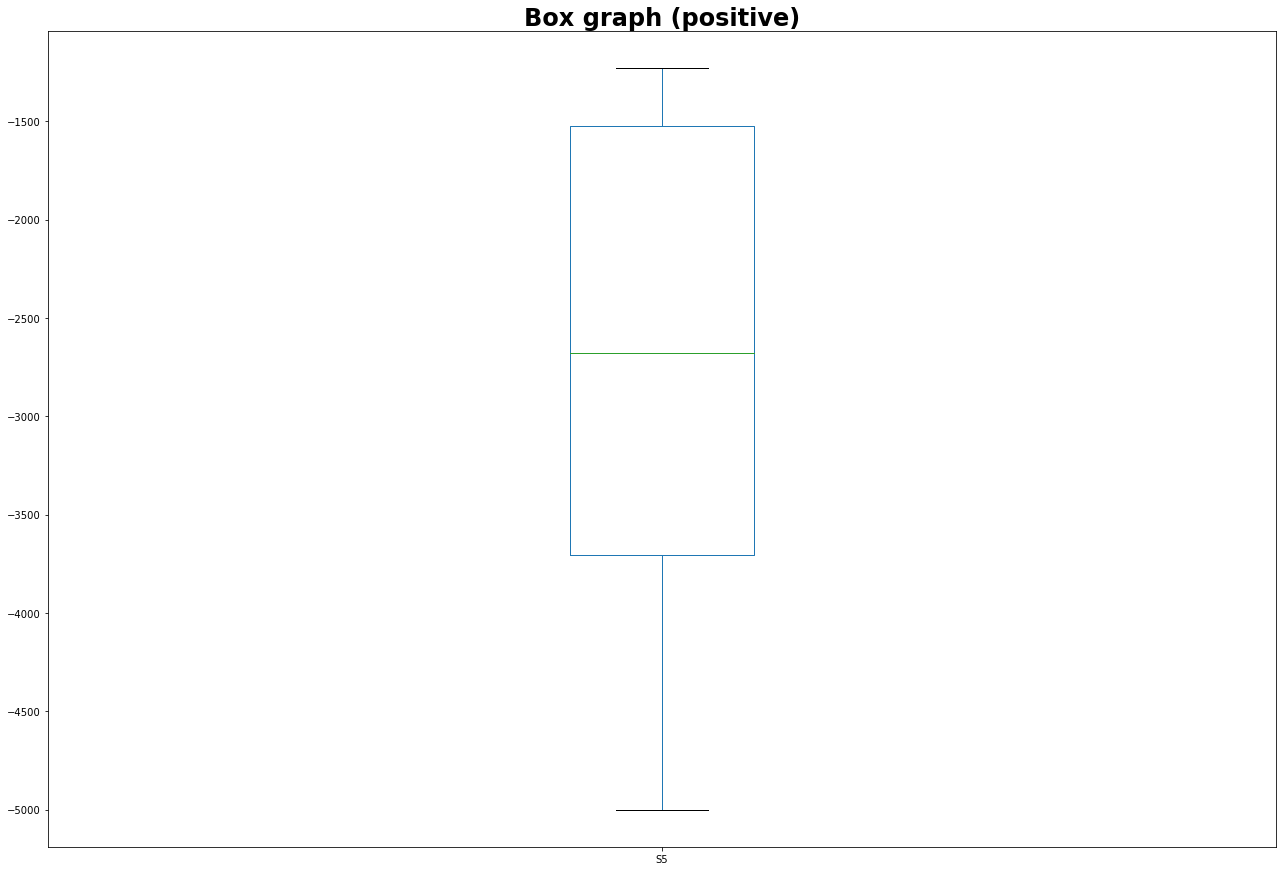

In [25]:
df_box_pos_graph = pd.DataFrame({
                    'Serial Number': positive_panel['Serial Number'],
                    'S5':  pd.to_numeric(positive_panel['Delta.S5 (T1-T2)']) })

box2_plot = df_box_pos_graph.plot.box(x='Serial Number', y='S5', legend = False, rot=0, figsize=(22,15))
plt.title("Box graph (positive)",fontweight="bold", fontsize=24)

box2_plot.get_figure().savefig("C:/ProgramData/National Instruments/Skyline/JupyterHub/box2_plot.png")


In [26]:
##combine both box graph
#df_box_pos_graph = pd.DataFrame({
#                    'Serial Number': positive_panel['Serial Number'],
#                    'S5_pos':  pd.to_numeric(positive_panel['Delta.S5 (T1-T2)']),
#                    'S5_neg':  pd.to_numeric(negative_panel['Delta.S5 (T1-T2)'])})
#
#box3_plot = df_box_pos_graph.plot.box(x='Serial Number', secondary_y=['S5_neg','S5_pos'], legend = False, rot=0, figsize=(13,10))

# Create into PDF

In [27]:
import weasyprint
from weasyprint import HTML
from jinja2 import Environment, FileSystemLoader

In [28]:
template_dir = 'C:/ProgramData/National Instruments/Skyline/JupyterHub'
env = Environment(loader=FileSystemLoader(searchpath = template_dir))
template = env.get_template("QCreportTemplate.html")
template_vars = {"title": "QC Batch Report",
                 "logo_alt": "ellume_icon",
                 "logo": "ellume_icon.png",
                 "system_info_table": df_system_info.to_html(header=False),
                 "negative_panel_table": df_negative_panel.to_html(header=False),
                 "positive_panel_table": df_positive_panel.to_html(header=False),
                 "assay_parameters_table": df_assay_panel.to_html(header=False),
                 "test_details_table": df_test_step.to_html(header=True),
                 "error_list_table": df_error_panel.to_html(header=True),
                 
                 "scatter_plot_alt": "Scatter Plot",
                 "scatter_plot": "scatter_plot.png",
                 "bar_plot_alt": "Bar Plot",
                 "bar_plot": "bar_plot.png",
                 "box1_plot_alt": "Box 1 Plot",
                 "box1_plot": "box1_plot.png",
                 "box2_plot_alt": "Box 2 Plot",
                 "box2_plot": "box2_plot.png"
                }
html_out = template.render(template_vars)

In [29]:
#Create PDF
start_time = datetime.now()
base_dir = 'C:/ProgramData/National Instruments/Skyline/JupyterHub/'
t = time.localtime()
time_stamp = time.strftime('%b-%d-%Y_%H_%M_%S', t)
file_name = "QC_Batch_Report_" + time_stamp  + '_' + Lot_Number + ".pdf"
HTML(string=html_out,base_url=template_dir).write_pdf(base_dir + file_name, 
                                                      stylesheets=["C:/ProgramData/National Instruments/Skyline/JupyterHub/typography_QC_A3.css"])
end_time = datetime.now()
total_time = (end_time - start_time).total_seconds()
display(total_time)

21.252999

### Upload file 

In [ ]:
server_url =" https://ausyslap01/#fileviewer/file"
files_api = file_ingestion.FilesApi()
response = await files_api.upload(base_dir + file_name)
file_id = response.uri.split("/")[-1:]
report_url = server_url + '/' + file_id[0]